In [1]:
import gc
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from helpers.funcs import resample, single_ts_split, timeseries_train_test_split as TSSplit, fit_model_cv, plotCoefficients
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
%matplotlib inline
NB_SEED = 123123

/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/berkkarahan/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  retu

In [2]:
def setindexdatetime(df, index_col):
    df[index_col] = pd.to_datetime(df[index_col])
    df.set_index(index_col, inplace=True)
    df = df.astype(np.float)
    return df

In [3]:
tr = setindexdatetime(pd.read_csv('valids/v_ready_iqr_tr.csv'),'Timestamp')
ts = setindexdatetime(pd.read_csv('valids/v_ready_iqr_ts.csv'),'Timestamp')
tr.index.freq = '15T'
ts = resample(ts)

/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:39: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  tseries.index[0], pd.tslib.Timestamp), 'Object must have a datetime-like index.'
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:73: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  tseries = tseries.resample(short_rate, how='mean').interpolate()
/home/berkkarahan/Desktop/tupras_isoforest/helpers/funcs.py:76: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).ffill()
  tseries = tseries.resample(rate, how='ffill')


In [4]:
tr_tr, tr_val = single_ts_split(tr.copy(),test_size=0.3)

In [6]:
tr_tr['Timestamp'] = tr_tr.index
tr_val['Timestamp'] = tr_val.index

In [7]:
tr_tr.to_csv('valids/tr_val/tr_train.csv', index=False)
tr_val.to_csv('valids/tr_val/tr_val.csv', index=False)

In [8]:
f = ((24*60)//15)
sd = seasonal_decompose(tr.Target, freq=f)

In [9]:
def make_sd_plots(sd, figsize=(40,20), save=False):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1,figsize=figsize)
    ax1.plot(sd.observed, label='observed')
    plt.legend(loc='upper left')
    ax2.plot(sd.trend, label='trend')
    plt.legend(loc='upper left')
    ax3.plot(sd.seasonal, label='seasonal')
    plt.legend(loc='upper left')
    ax4.plot(sd.resid, label='residual')
    plt.legend(loc='upper left')
    plt.title('Seasonal Decomposition')

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


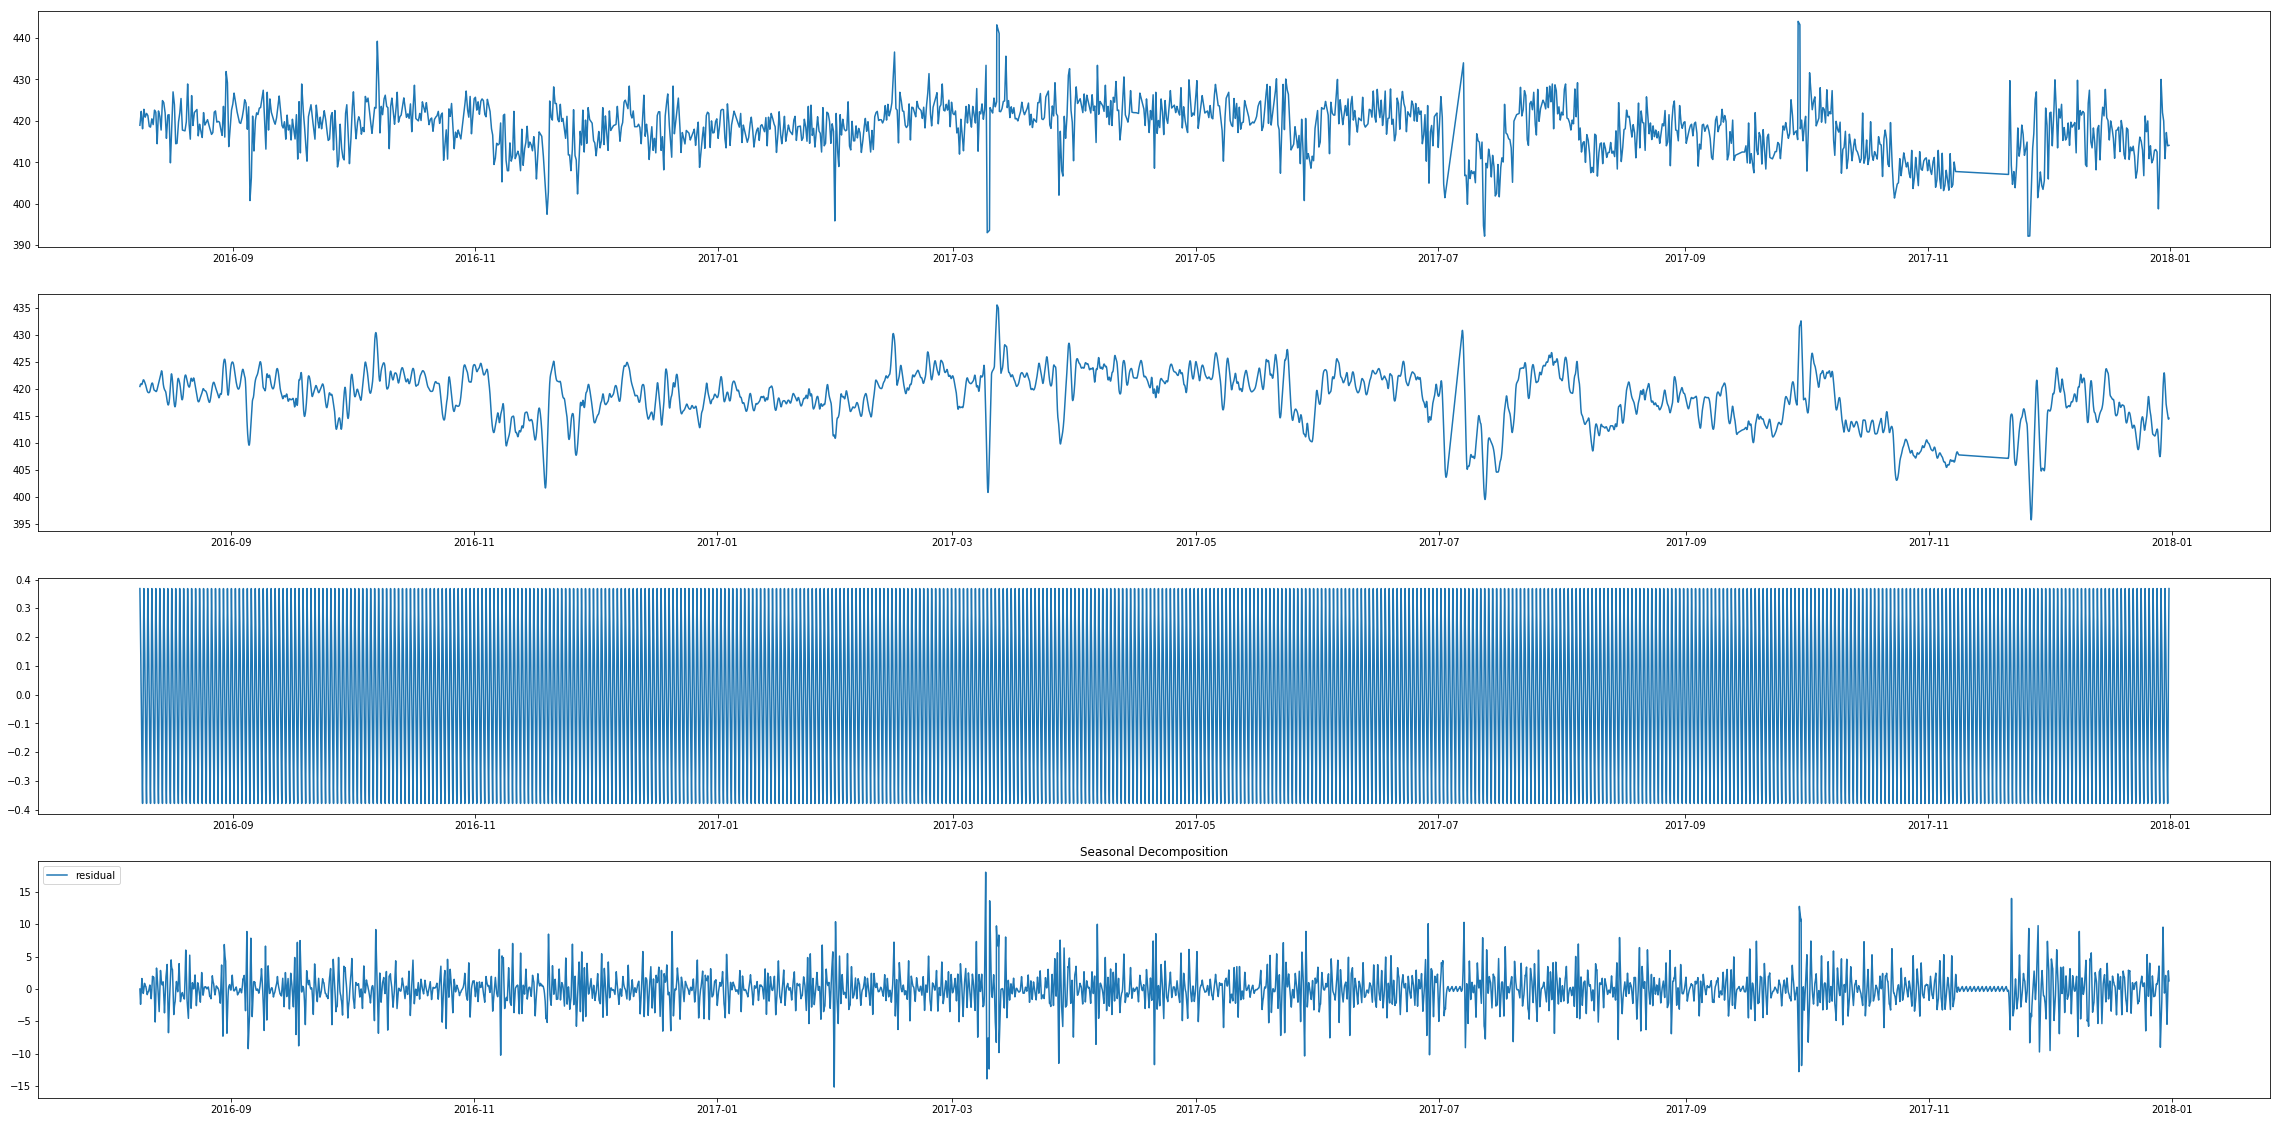

In [10]:
make_sd_plots(sd)

In [16]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window=12):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(20, 10))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

In [17]:
def difference_n(timeseries, n):
    timeseries = timeseries - timeseries.shift(n)
    return timeseries.dropna()

In [18]:
#hourly freq series
hourly = tr.Target.copy().resample('H', base=00).interpolate(how='time')
#6hrly freq series
hourly_6 = tr.Target.copy().resample('6H', base=00).interpolate(how='time')
#12hrly freq series
hourly_12 = tr.Target.copy().resample('12H', base=00).interpolate(how='time')
#daily freq series
daily = tr.Target.copy().resample('D').interpolate(how='time')

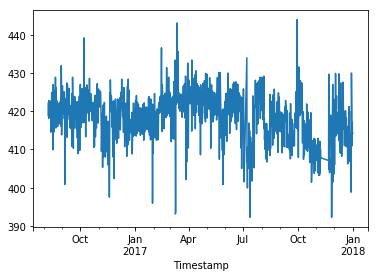

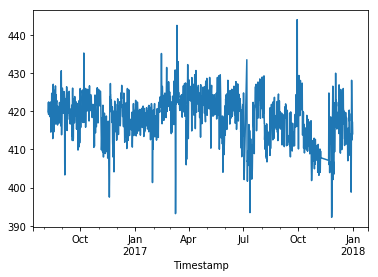

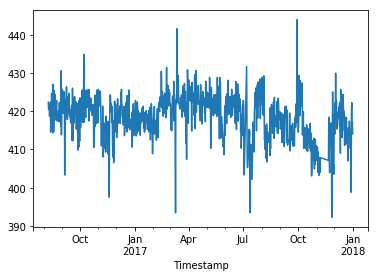

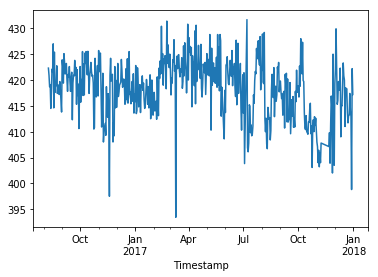

In [19]:
hourly.plot()
plt.show()
hourly_6.plot()
plt.show()
hourly_12.plot()
plt.show()
daily.plot()
plt.show()

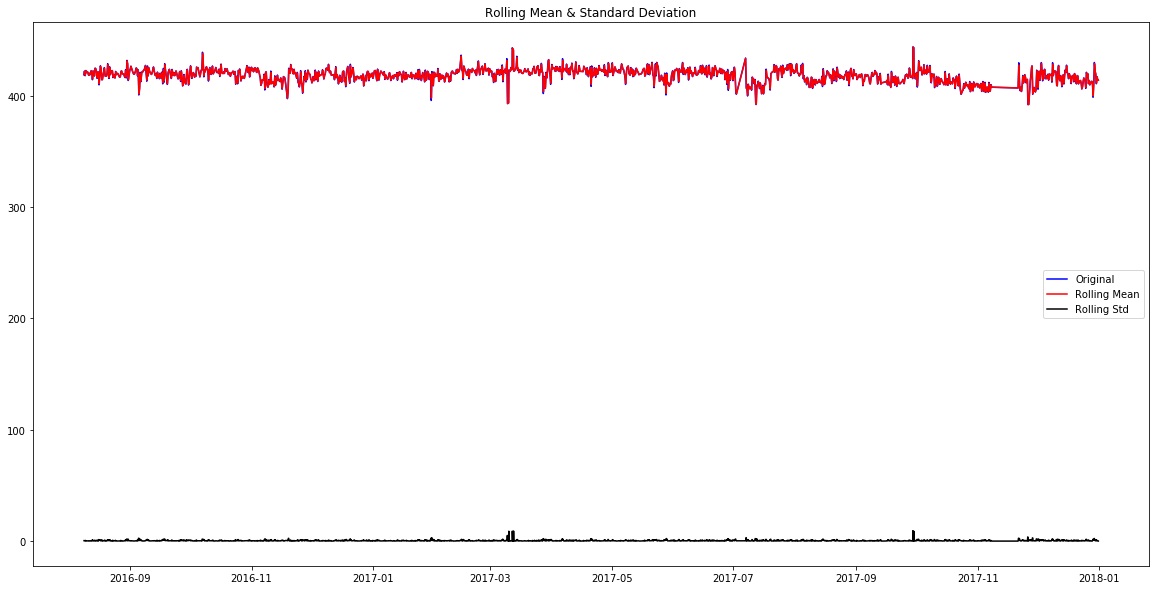

Results of Dickey-Fuller Test:
Test Statistic                -1.154172e+01
p-value                        3.621034e-21
#Lags Used                     5.600000e+01
Number of Observations Used    4.890400e+04
Critical Value (1%)           -3.430484e+00
Critical Value (5%)           -2.861599e+00
Critical Value (10%)          -2.566801e+00
dtype: float64


In [20]:
#stationary test of initial timeseries
test_stationarity(tr.Target)

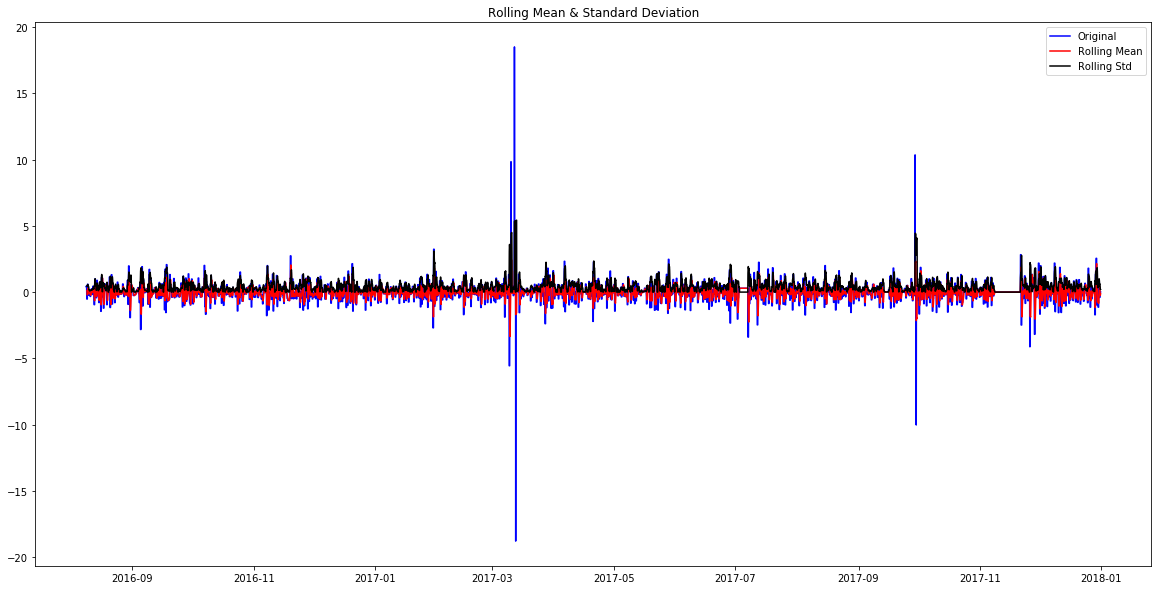

Results of Dickey-Fuller Test:
Test Statistic                   -23.204016
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    12199.000000
Critical Value (1%)               -3.430886
Critical Value (5%)               -2.861777
Critical Value (10%)              -2.566896
dtype: float64


In [21]:
#hourly stationarization check, hourly differencing might work. Check others.
fd = difference_n(hourly,1)
test_stationarity(fd)

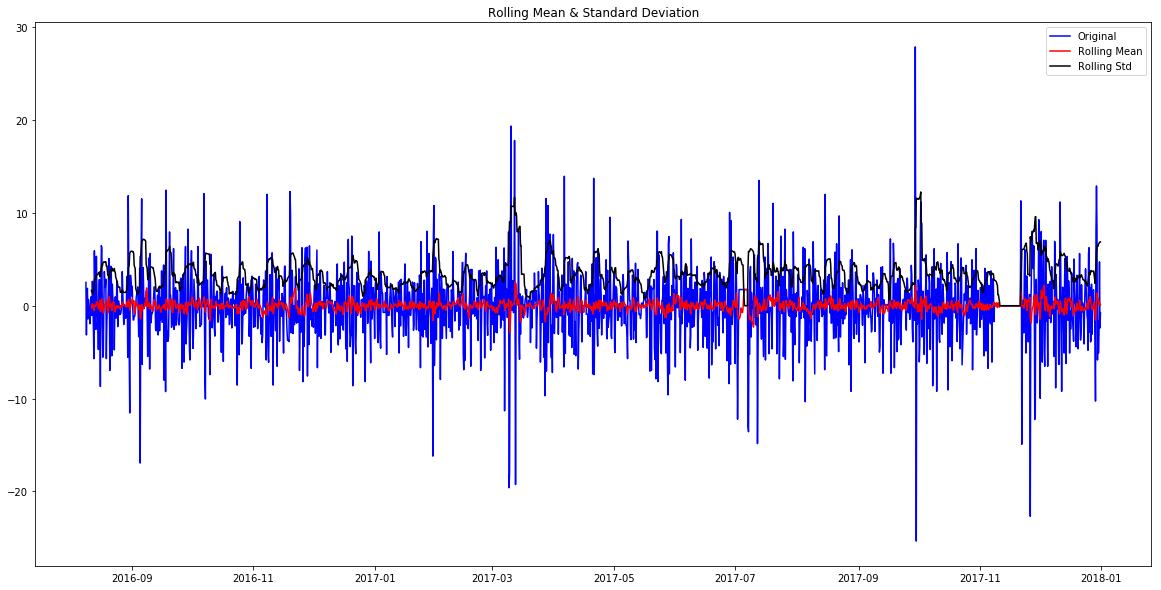

Results of Dickey-Fuller Test:
Test Statistic                -1.240638e+01
p-value                        4.442951e-23
#Lags Used                     2.600000e+01
Number of Observations Used    2.012000e+03
Critical Value (1%)           -3.433604e+00
Critical Value (5%)           -2.862978e+00
Critical Value (10%)          -2.567535e+00
dtype: float64


In [22]:
fd = difference_n(hourly_6,1)
test_stationarity(fd)

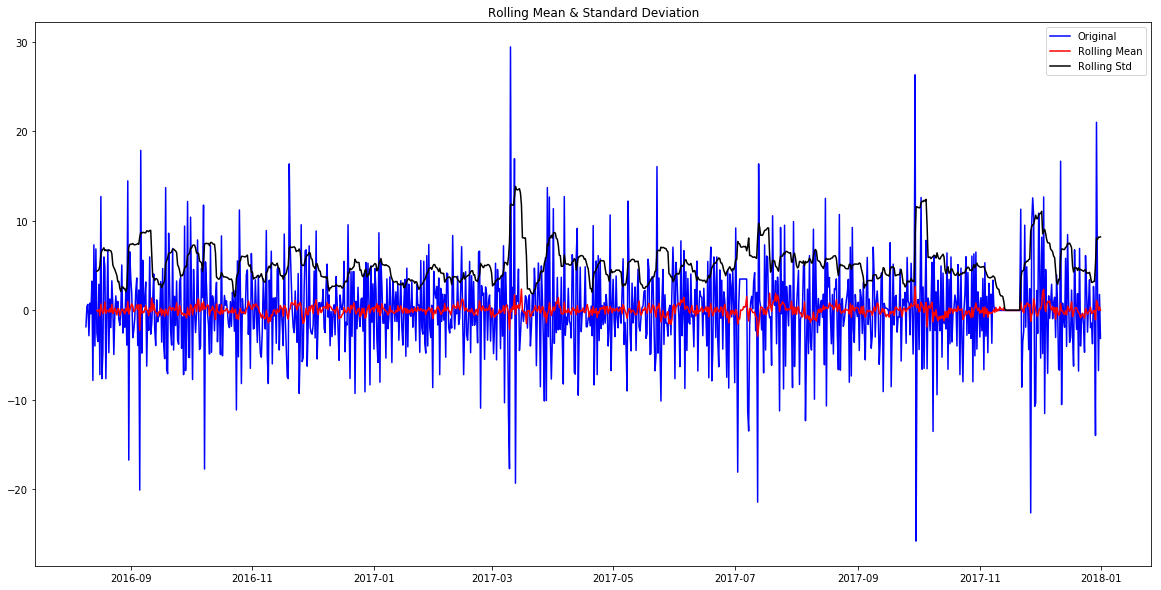

Results of Dickey-Fuller Test:
Test Statistic                -1.498697e+01
p-value                        1.140069e-27
#Lags Used                     9.000000e+00
Number of Observations Used    1.009000e+03
Critical Value (1%)           -3.436848e+00
Critical Value (5%)           -2.864409e+00
Critical Value (10%)          -2.568297e+00
dtype: float64


In [23]:
fd = difference_n(hourly_12,1)
test_stationarity(fd)

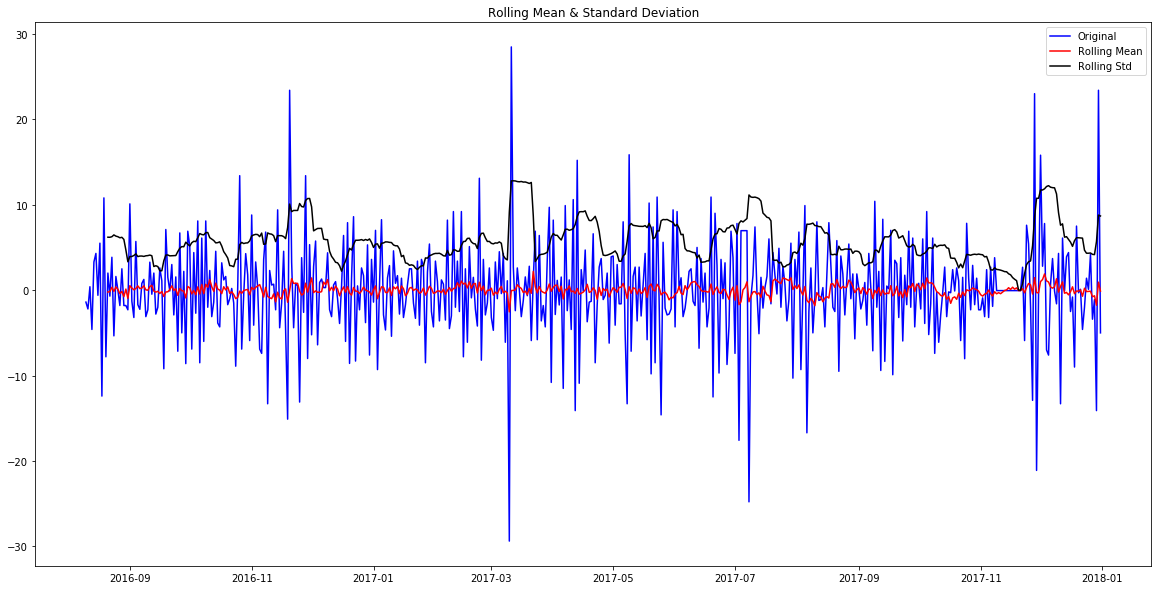

Results of Dickey-Fuller Test:
Test Statistic                -1.451797e+01
p-value                        5.584400e-27
#Lags Used                     5.000000e+00
Number of Observations Used    5.030000e+02
Critical Value (1%)           -3.443418e+00
Critical Value (5%)           -2.867303e+00
Critical Value (10%)          -2.569840e+00
dtype: float64


In [24]:
fd = difference_n(daily,1)
test_stationarity(fd)

In [16]:
#cleanup
del hourly, hourly_6, hourly_12, daily, fd;gc.collect()

20685

In [34]:
#Best p-value for differencing is for 1 hourly differencing.
#First split to train and test
y_tr, y_ts = single_ts_split(tr.Target.copy(), test_size=0.3)

In [45]:
import copy
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [57]:
c_list=[]
for i, tpl in enumerate(tscv.split(y_tr)):
    print(str(i) + "-th iteration started...")
    tr_i = tpl[0]
    y_ = y_tr.copy()[tr_i]
    rf = auto_arima(y_,
                start_p=1,
                start_q=1,
                max_p=3,
                max_q=3,
                seasonal=True,
                max_P=3,
                max_Q=3,
                D = 4,
                max_D = 4,
                m = 4,
                trace=True,
                error_action='ignore',
                suppress_warnings=True,
                stepwise=False,
                random=True,
                n_jobs=-1,
                random_state=NB_SEED)
    c_list.append(rf)
    
    

0-th iteration started...
Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(2, 4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(2, 4, 3, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(2, 4, 3, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 4, 2, 4); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 3) seasonal_order=(1, 4, 1, 4); AIC=-11817.417, BIC=-11757.589, Fit time=59.879 seconds
Fit ARIMA: order=(1, 0, 3) seasonal_order=(2, 4, 1, 4); AIC=-11899.801, BIC=-11839.974, Fit time=76.462 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(3, 4, 1, 4); AIC=-12018.964, BIC=-11952.489, Fit time=94.896 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(3, 4, 1, 4); AIC=-12484.6

MaybeEncodingError: Error sending result: '[ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 0, 3),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(3, 4, 1, 4), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')]'. Reason: 'error("'i' format requires -2147483648 <= number <= 2147483647",)'

In [72]:
from sklearn.externals import joblib
import pickle
for i, mdl in enumerate(c_list):
    joblib.dump

[ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 0, 3),
    out_of_sample_size=0, scoring='mse', scoring_args={},
    seasonal_order=(3, 4, 1, 4), solver='lbfgs', start_params=None,
    suppress_warnings=True, transparams=True, trend='c'),
 ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 0, 3),
    out_of_sample_size=0, scoring='mse', scoring_args={},
    seasonal_order=(1, 4, 1, 4), solver='lbfgs', start_params=None,
    suppress_warnings=True, transparams=True, trend='c'),
 ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 0, 3),
    out_of_sample_size=0, scoring='mse', scoring_args={},
    seasonal_order=(3, 4, 1, 4), solver='lbfgs', start_params=None,
    suppress_warnings=True, transparams=True, trend='c'),
 ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 0, 3),
    out_of_sample_size=0, scoring='mse', scoring_args={},
    seasonal_order=(1, 4, 1, 4), solver='lbfgs', start_params=None,
    suppress_warnings=True, transp

In [75]:
cvpreds = np.empty(shape=(y_ts.shape[0],len(c_list)))
for i, amdl in enumerate(c_list):
    y_pred = amdl.predict(n_periods=y_ts.shape[0])
    cvpreds[:,i] = y_pred
    


In [77]:
cvpreds = np.mean(cvpreds, axis=1)

In [79]:
cvpreds = pd.Series(data=cvpreds, index=y_ts.index)

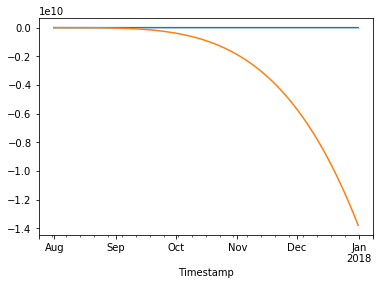

In [80]:
y_ts.plot()
cvpreds.plot()

In [84]:
#metrics
mse = mean_squared_error(y_ts,cvpreds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_ts,cvpreds)
r2 = r2_score(y_ts,cvpreds)

In [85]:
#mse
print(mse)

2.142083230757495e+19


In [86]:
#rmse
print(rmse)

4628264502.767203


In [87]:
#mae
print(mae)

2795319047.580136


In [88]:
#r2
print(r2)

-6.004396084198067e+17
